# Resolution and Other Evaluation Tools 

* [resolution plots gnn](https://gitlab.cern.ch/lasalle/ecal-reco-gnn/-/blob/master/scripts/eval/resolution_plots_gnn.cpp)
* [resolution helpers](https://gitlab.cern.ch/lasalle/ecal-reco-gnn/-/blob/master/scripts/eval/resolution_helpers.h)
* [eval](https://gitlab.cern.ch/lasalle/ecal-reco-gnn/-/blob/master/src/ecal_reco_gnn/eval.py?ref_type=head)
* [resolution plots v4](https://gitlab.cern.ch/lasalle/ecal-reco-gnn/-/blob/master/scripts/resolution/resolution_plots_v4.cpp)

In [3]:
import mplhep
import uproot

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold 
from xgboost import XGBClassifier 

import awkward as ak

import pandas as pd 
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
def uprootOpenFile(filePath, decayTree='cluster'):
    with uproot.open(filePath) as file:
        df = file[decayTree].arrays(library='ak')
    
    return df

In [5]:
# Output reconstruction from reco_Run5_rotated_singlephoton.py

df = uprootOpenFile("myReconstruction_photon_Run5_rotated_2023_baseline_seeding0.root")

In [6]:
df

<Array [{evtNumber: 1, ID: 1705003, ...}, ...] type='4 * {evtNumber: int32,...'>

In [7]:
filepath="/eos/user/c/ciperez/lhcb_reco/"

In [8]:
!ls $filepath

NegPions_PGun.root  Photons_PGun.root


In [9]:
pho_df = uprootOpenFile(f"{filepath}/Photons_PGun.root", "photons")

In [10]:
pho_pd_df = ak.to_dataframe(pho_df)

In [18]:
df = pho_pd_df

In [16]:
df_3x3_clustering_pd = ak.to_dataframe(df)

In [17]:
df_3x3_clustering_pd

evtNumber       ID  nCandidate       ly      lyF      lyB  \
entry subentry                                                              
0     0                 1  1705003           0    951.0      0.0    951.0   
      1                 1  1705003           0    951.0      0.0    951.0   
      2                 1  1705003           0    951.0      0.0    951.0   
      3                 1  1705003           0    951.0      0.0    951.0   
      4                 1  1705003           0    951.0      0.0    951.0   
      5                 1  1705003           0    951.0      0.0    951.0   
      6                 1  1705003           0    951.0      0.0    951.0   
      7                 1  1705003           0    951.0      0.0    951.0   
      8                 1  1705003           0    951.0      0.0    951.0   
1     0                 1  1706002           1  11113.0    800.0  10313.0   
      1                 1  1706002           1  11113.0    800.0  10313.0   
      2                 1  1706002           1  11113.0    800.0  10313.0   
      3                 1  1706002           1  11113.0    800.0  10313.0   
      4                 1  1706002           1  11113.0    800.0  10313.0   
      5                 1  1706002           1  11113.0    800.0  10313.0   
      6                 1  1706002           1  11113.0    800.0  10313.0   
      7                 1  1706002           1  11113.0    800.0  10313.0   
      8                 1  1706002           1  11113.0    800.0  10313.0   
2     0                 1  1727001           2   1774.0    820.0    954.0   
      1                 1  1727001           2   1774.0    820.0    954.0   
      2                 1  1727001           2   1774.0    820.0    954.0   
      3                 1  1727001           2   1774.0    820.0    954.0   
      4                 1  1727001           2   1774.0    820.0    954.0   
      5                 1  1727001           2   1774.0    820.0    954.0   
      6                 1  1727001           2   1774.0    820.0    954.0   
      7                 1  1727001           2   1774.0    820.0    954.0   
      8                 1  1727001           2   1774.0    820.0    954.0   
3     0                 1  1728000           3  35608.0  14773.0  20835.0   
      1                 1  1728000           3  35608.0  14773.0  20835.0   
      2                 1  1728000           3  35608.0  14773.0  20835.0   
      3                 1  1728000           3  35608.0  14773.0  20835.0   
      4                 1  1728000           3  35608.0  14773.0  20835.0   
      5                 1  1728000           3  35608.0  14773.0  20835.0   
      6                 1  1728000           3  35608.0  14773.0  20835.0   
      7                 1  1728000           3  35608.0  14773.0  20835.0   
      8                 1  1728000           3  35608.0  14773.0  20835.0   

                          x            y             z  anglex  ...  \
entry subentry                                                  ...   
0     0        -2860.252550   446.441017  12707.354533    -0.0  ...   
      1        -2860.252550   446.441017  12707.354533    -0.0  ...   
      2        -2860.252550   446.441017  12707.354533    -0.0  ...   
      3        -2860.252550   446.441017  12707.354533    -0.0  ...   
      4        -2860.252550   446.441017  12707.354533    -0.0  ...   
      5        -2860.252550   446.441017  12707.354533    -0.0  ...   
      6        -2860.252550   446.441017  12707.354533    -0.0  ...   
      7        -2860.252550   446.441017  12707.354533    -0.0  ...   
      8        -2860.252550   446.441017  12707.354533    -0.0  ...   
1     0         2885.479787  -441.703717  12752.834679     0.0  ...   
      1         2885.479787  -441.703717  12752.834679     0.0  ...   
      2         2885.479787  -441.703717  12752.834679     0.0  ...   
      3         2885.479787  -441.703717  12752.834679     0.0  ...   
      4         2885.479

In [19]:
import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.data import DataLoader

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the edges as tuples of feature column names (corresponding to indices of nodes)
edges = [('F1', 'F2'), ('F2', 'F3'), ('F4', 'F5'), ('F5', 'F6'), 
         ('F7', 'F8'), ('F8', 'F9'), ('F5', 'F2'), ('F5', 'F8'),
         # Add edges connecting 'F' columns to 'B' columns if needed
         ('F1', 'B1'), ('F2', 'B2'), ('F3', 'B3'), ('F4', 'B4'),
         ('F5', 'B5'), ('F6', 'B6'), ('F7', 'B7'), ('F8', 'B8'),
         ('F9', 'B9'),
         # Back planes connected:
         ('B1', 'B2'), ('B2', 'B3'), ('B4', 'B5'), ('B5', 'B6'), 
         ('B7', 'B8'), ('B8', 'B9'), ('B5', 'B2'), ('B5', 'B8'),
        ]

# Create a combined list of feature columns from both 'F' and 'B'
feature_columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
                   'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

# Create edge_index from the feature columns
edge_index = []
for edge in edges:
    # Get the indices of the nodes in the edge
    edge_index.append([feature_columns.index(edge[0]), feature_columns.index(edge[1])])

# Convert the list to a tensor and move to device
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)

# Node features (include both 'F' and 'B' columns)
features = df[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 
               'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']].values
features = torch.tensor(features, dtype=torch.float).to(device)

# Target values (EtotF and EtotB)
y = df[['EtotF', 'EtotB']].values
y = torch.tensor(y, dtype=torch.float).to(device)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index, y=y)

In [21]:
from sklearn.preprocessing import StandardScaler

# Normalize the target values
scaler_y = StandardScaler()
data.y = torch.tensor(scaler_y.fit_transform(data.y.cpu().numpy()), dtype=torch.float32).to(device)

# Normalize the feature values
scaler_x = StandardScaler()
data.x = torch.tensor(scaler_x.fit_transform(data.x.cpu().numpy()), dtype=torch.float32).to(device)

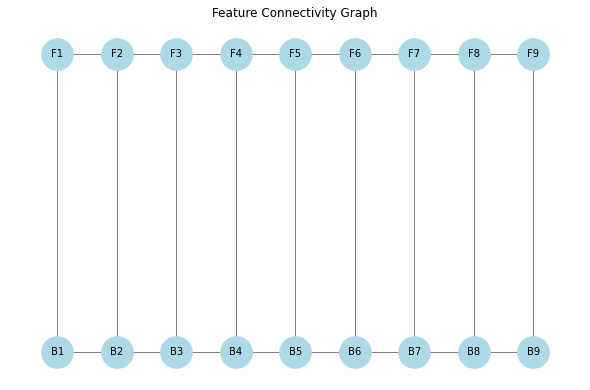

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

#### This is not the correct connections of nodes. It's too simplistic an assumption. 
# It should be dynamic at each event 

# Define the edges as tuples
# edges = [('F1', 'F2'), ('F2', 'F3'), ('F4', 'F5'), ('F5', 'F6'), 
#          ('F7', 'F8'), ('F8', 'F9'), ('F5', 'F2'), ('F5', 'F8'),
#          ('F1', 'B1'), ('F2', 'B2'), ('F3', 'B3'), ('F4', 'B4'),
#          ('F5', 'B5'), ('F6', 'B6'), ('F7', 'B7'), ('F8', 'B8'),
#          ('F9', 'B9')]

# Create a graph
G = nx.Graph()
G.add_edges_from(edges)

# Define positions: F nodes on top, B nodes on bottom
pos = {}
for i, f in enumerate(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']):
    pos[f] = (i, 1)  # Row 1
for i, b in enumerate(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']):
    pos[b] = (i, 0)  # Row 0

# Draw the graph
plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1000, font_size=10)
plt.title("Feature Connectivity Graph")
plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATModel, self).__init__()
        # First GAT layer
        self.conv1 = GATConv(input_dim, hidden_dim, heads=1, dropout=0.2)
        # Second GAT layer
        self.conv2 = GATConv(hidden_dim, output_dim, heads=1, dropout=0.2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # First GAT layer
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        
        return x

Epoch 10/400, Loss: 1.2221, MAE: 0.2562
Epoch 20/400, Loss: 0.7421, MAE: 0.2298
Epoch 30/400, Loss: 0.5811, MAE: 0.2143
Epoch 40/400, Loss: 0.5212, MAE: 0.1954
Epoch 50/400, Loss: 0.4787, MAE: 0.1866
Epoch 60/400, Loss: 0.4619, MAE: 0.1800
Epoch 70/400, Loss: 0.4584, MAE: 0.1737
Epoch 80/400, Loss: 0.4602, MAE: 0.1741
Epoch 90/400, Loss: 0.4538, MAE: 0.1706
Epoch 100/400, Loss: 0.4252, MAE: 0.1679
Epoch 110/400, Loss: 0.4523, MAE: 0.1690
Epoch 120/400, Loss: 0.4486, MAE: 0.1674
Epoch 130/400, Loss: 0.4272, MAE: 0.1661
Epoch 140/400, Loss: 0.4142, MAE: 0.1637
Epoch 150/400, Loss: 0.4253, MAE: 0.1637
Epoch 160/400, Loss: 0.4253, MAE: 0.1627
Epoch 170/400, Loss: 0.4225, MAE: 0.1616
Epoch 180/400, Loss: 0.4110, MAE: 0.1602
Epoch 190/400, Loss: 0.4118, MAE: 0.1600
Epoch 200/400, Loss: 0.4148, MAE: 0.1596
Epoch 210/400, Loss: 0.4172, MAE: 0.1596
Epoch 220/400, Loss: 0.4320, MAE: 0.1606
Epoch 230/400, Loss: 0.4056, MAE: 0.1586
Epoch 240/400, Loss: 0.3940, MAE: 0.1566
Epoch 250/400, Loss: 0.40

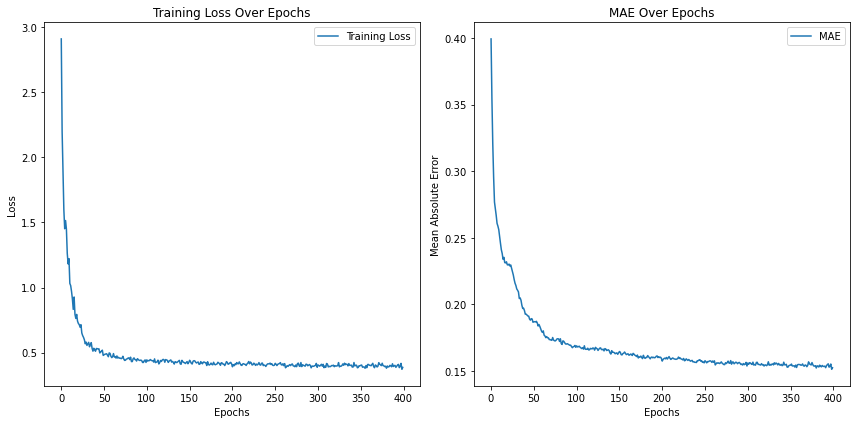

Evaluation - MSE: 0.1643, MAE: 0.1319


In [24]:
from torch_geometric.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set device (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data to device
data = data.to(device)

# Define model
input_dim = data.x.shape[1]  # Number of features per node
hidden_dim = 64  # Hidden dimension size
output_dim = 2  # Predicting EtotF and EtotB

model = GATModel(input_dim, hidden_dim, output_dim).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.MSELoss()

# Train the model
def train(model, data, optimizer, criterion, epochs=400):
    model.train()
    train_losses = []
    mae_scores = []  # List to store the MAE scores for each epoch
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        
        # Calculate MAE (Mean Absolute Error)
        mae = mean_absolute_error(data.y.cpu().numpy(), out.cpu().detach().numpy())
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        train_losses.append(loss.item())
        mae_scores.append(mae)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, MAE: {mae:.4f}')
    
    return train_losses, mae_scores

# Train the model for 100 epochs
train_losses, mae_scores = train(model, data, optimizer, criterion, epochs=400)

# Plot training loss and MAE
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(mae_scores, label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        mse = mean_squared_error(data.y.cpu().numpy(), out.cpu().numpy())  # MSE
        mae = mean_absolute_error(data.y.cpu().numpy(), out.cpu().numpy())  # MAE
    return mse, mae

# Get MSE and MAE on the test data
mse, mae = evaluate(model, data)
print(f'Evaluation - MSE: {mse:.4f}, MAE: {mae:.4f}')


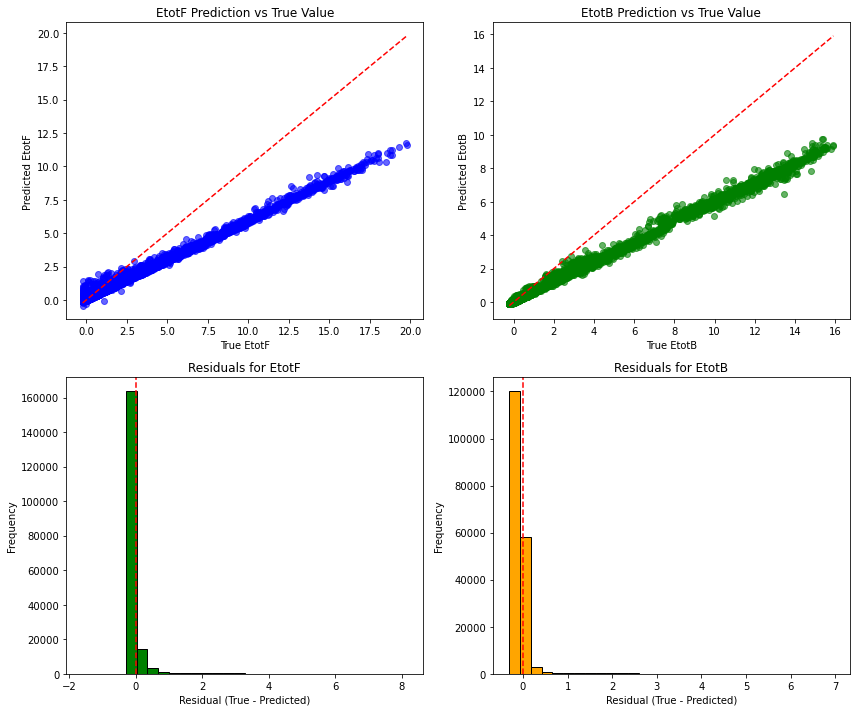

In [94]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions_and_residuals(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        true_values = data.y.cpu()
        predicted_values = predictions.cpu()

        residuals_f = true_values[:, 0] - predicted_values[:, 0]
        residuals_b = true_values[:, 1] - predicted_values[:, 1]

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Scatter plot for EtotF
        axes[0, 0].scatter(true_values[:, 0], predicted_values[:, 0], color='blue', alpha=0.6)
        axes[0, 0].plot([true_values[:, 0].min(), true_values[:, 0].max()], 
                        [true_values[:, 0].min(), true_values[:, 0].max()], color='red', linestyle='--')
        axes[0, 0].set_xlabel('True EtotF')
        axes[0, 0].set_ylabel('Predicted EtotF')
        axes[0, 0].set_title('EtotF Prediction vs True Value')

        # Scatter plot for EtotB
        axes[0, 1].scatter(true_values[:, 1], predicted_values[:, 1], color='green', alpha=0.6)
        axes[0, 1].plot([true_values[:, 1].min(), true_values[:, 1].max()], 
                        [true_values[:, 1].min(), true_values[:, 1].max()], color='red', linestyle='--')
        axes[0, 1].set_xlabel('True EtotB')
        axes[0, 1].set_ylabel('Predicted EtotB')
        axes[0, 1].set_title('EtotB Prediction vs True Value')

        # Histogram of residuals for EtotF
        axes[1, 0].hist(residuals_f.numpy(), bins=30, color='green', edgecolor='black')
        axes[1, 0].axvline(0, color='red', linestyle='--')  # Reference line at 0
        axes[1, 0].set_xlabel('Residual (True - Predicted)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Residuals for EtotF')

        # Histogram of residuals for EtotB
        axes[1, 1].hist(residuals_b.numpy(), bins=30, color='orange', edgecolor='black')
        axes[1, 1].axvline(0, color='red', linestyle='--')  # Reference line at 0
        axes[1, 1].set_xlabel('Residual (True - Predicted)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Residuals for EtotB')

        plt.tight_layout()
        plt.show()

# Visualize predictions and residuals
visualize_predictions_and_residuals(model, data)


In [95]:
import zfit

def fit_and_plot(true_values, predicted_values, title='Fit Plot'):
    residuals = (predicted_values - true_values) / true_values
    
    # Ensure residuals is a NumPy array
    if isinstance(residuals, torch.Tensor):
        residuals = residuals.detach().cpu().numpy()  # Detach and move to CPU if necessary
    
    # Define fit range 
    lower, upper = residuals.min(), residuals.max()
    
    # Define the observable
    obs = zfit.Space("residuals", limits=(lower, upper))
    
    # Create dataset
    data = zfit.Data.from_numpy(obs=obs, array=residuals)
    
    # Define parameters for Gaussian fit
    mu = zfit.Parameter("mu", np.mean(residuals), lower=np.min(residuals), upper=np.max(residuals))

    sigma_value = np.std(residuals)
    sigma = zfit.Parameter("sigma", sigma_value, lower=0.1 * sigma_value, upper=2 * sigma_value)

    gauss = zfit.pdf.Gauss(mu, sigma, obs=obs)
    
    # Fit model 
    nll       = zfit.loss.UnbinnedNLL(model=gauss, data=data)
    minimizer = zfit.minimize.Minuit()
    result    = minimizer.minimize(nll)
    
    # Sample from the fitted distribution
    x_vals = np.linspace(lower, upper, 100)
    y_vals = gauss.pdf(x_vals).numpy()
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Data')
    plt.plot(x_vals, y_vals, color='red', lw=2, label="Gaussian Fit")
    plt.axvline(0, color='black', linestyle='--', lw=1)
    plt.xlabel(r'$(E_{\mathrm{rec}} - E_{\mathrm{true}}) / E_{\mathrm{true}}$')
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.show()

In [96]:
model.eval()
with torch.no_grad(): # important to disable gradients... Not necessary here and we want np arrays instead of tensors
    predictions = model(data)
    true_values = data.y.cpu()
    predicted_values = predictions.cpu()


#residuals_f = true_values[:, 0] - predicted_values[:, 0]
#residuals_b = true_values[:, 1] - predicted_values[:, 1]

In [68]:
predictions

tensor([[-0.1348, -0.1229],
        [-0.1346, -0.1228],
        [-0.1343, -0.1226],
        ...,
        [-0.1289, -0.1165],
        [-0.1290, -0.1169],
        [-0.1265, -0.1174]], device='cuda:0')

In [69]:
true_values

tensor([[-0.2288, -0.2128],
        [-0.2280, -0.2129],
        [-0.2282, -0.2129],
        ...,
        [-0.2165, -0.2011],
        [-0.2168, -0.2013],
        [-0.2114, -0.2044]])

In [70]:
predicted_values

tensor([[-0.1348, -0.1229],
        [-0.1346, -0.1228],
        [-0.1343, -0.1226],
        ...,
        [-0.1289, -0.1165],
        [-0.1290, -0.1169],
        [-0.1265, -0.1174]])

In [71]:
true_values_F      = true_values[:, 0]
predicted_values_F = predicted_values[:, 0]

In [72]:
true_values_F

tensor([-0.2288, -0.2280, -0.2282,  ..., -0.2165, -0.2168, -0.2114])

In [73]:
true_values_B      = true_values[:, 1]
predicted_values_B = predicted_values[:, 1]

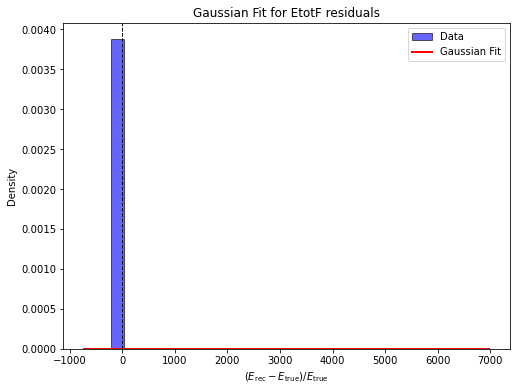

In [74]:
fit_and_plot(true_values_F, predicted_values_F, title="Gaussian Fit for EtotF residuals")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import zfit

def fit_and_plot_DB(true_values, predicted_values, title):
    # Compute residuals
    residuals = np.array(true_values - predicted_values)  # Ensure it's NumPy
    
#     # Ensure residuals is a NumPy array
#     if isinstance(residuals, torch.Tensor):
#         residuals = residuals.detach().cpu().numpy()  # Detach and move to CPU if necessary

    # Define observable
    obs = zfit.Space("x", limits=(np.min(residuals), np.max(residuals)))

    # Create dataset
    data = zfit.Data.from_numpy(obs=obs, array=residuals)

    # Define parameters for DCB
    mu = zfit.Parameter("mu", np.mean(residuals), lower=np.min(residuals), upper=np.max(residuals))
    print(np.std(residuals))
    #sigma = zfit.Parameter("sigma", np.std(residuals), lower=0.01 * np.std(residuals), upper=1.0 * np.std(residuals))
    sigma = zfit.Parameter("sigma", np.std(residuals), lower=0.01, upper=1.0)
    alpha_L = zfit.Parameter("alpha_L", 1.5, lower=0.01, upper=2)  # Left tail slope
    n_L = zfit.Parameter("n_L", 3, lower=1, upper=10)             # Left tail exponent
    alpha_R = zfit.Parameter("alpha_R", 1.5, lower=0.01, upper=2)  # Right tail slope
    n_R = zfit.Parameter("n_R", 3, lower=1, upper=10)             # Right tail exponent

    # Define double Crystal Ball function
    
    #dcb = zfit.pdf.CrystalBall(mu=mu, sigma=sigma, alpha=alpha_L, n=n_L, obs=obs) + \
    #      zfit.pdf.CrystalBall(mu=mu, sigma=sigma, alpha=alpha_R, n=n_R, obs=obs) 
    
    # This item has been removed due to an API change. Instruction to update:
    #Adding (non-extended) pdfs is not allowed anymore due to disambiguity.Use the `zfit.pdf.SumPDF([pdf, other_pdf], frac)` syntax instead.
    
    dcb_l = zfit.pdf.CrystalBall(mu=mu, sigma=sigma, alpha=alpha_L, n=n_L, obs=obs)
    dcb_r = zfit.pdf.CrystalBall(mu=mu, sigma=sigma, alpha=alpha_R, n=n_R, obs=obs)
    
    # Define fraction parameter for combining the two components
    frac = zfit.Parameter("frac", 0.5, lower=0.01, upper=0.99)
    
    dcb = zfit.pdf.SumPDF([dcb_l, dcb_r], fracs=frac)

    # Create loss and minimizer
    loss = zfit.loss.UnbinnedNLL(model=dcb, data=data)
    minimizer = zfit.minimize.Minuit()

    # Perform minimization (fit)
    result = minimizer.minimize(loss)
    param_values = result.params
    print("Fit results:", param_values)

    # Generate fitted curve for plotting
    x_vals = np.linspace(np.min(residuals), np.max(residuals), 1000)
    y_vals = dcb.pdf(x_vals, norm_range=obs)
    
    # Plot results
    plt.hist(residuals, bins=100, density=True, alpha=0.6, color='g', label="Data")
    plt.plot(x_vals, y_vals, 'r-', label="Double Crystal Ball Fit")
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.legend()
    plt.title(title)
    plt.show()


0.40621585
Fit results: name       value  (rounded)    at limit
-------  ------------------  ----------
frac              0.0119574       False
mu              -0.00452997       False
sigma              0.407826       False
alpha_L                   2        True
n_L                      10        True
alpha_R                   2        True
n_R                      10        True


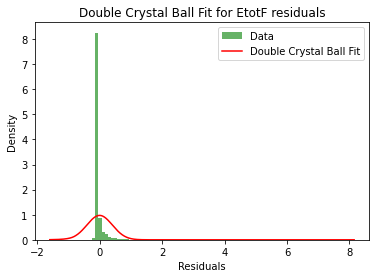

In [117]:
fit_and_plot_DB(true_values_F, predicted_values_F, title="Double Crystal Ball Fit for EtotF residuals")

The tails fall off faster necessitating larger nL and nR

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def calculate_rms90(values):
    """Calculate RMS90 value (RMS of central 90% of distribution)"""
    sorted_vals = np.sort(values)
    n = len(values)
    start_idx = int(0.05 * n)
    end_idx = int(0.95 * n)
    central_90 = sorted_vals[start_idx:end_idx]
    return np.sqrt(np.mean(central_90**2))

def fit_and_plot_scipy(true_values, predicted_values, title="Fit Plot", bins=50):
    # Calculate residuals
    residuals = (predicted_values - true_values) / true_values
    # Ensure residuals is a NumPy array
    if isinstance(residuals, torch.Tensor):
        residuals = residuals.detach().cpu().numpy()  # Detach and move to CPU if necessary
    
    # Create histogram
    hist, bin_edges = np.histogram(residuals, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Fit Gaussian
    p0 = [np.max(hist), np.mean(residuals), np.std(residuals)]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=p0)
    
    # Calculate errors for histogram bins
    hist_errors = np.sqrt(hist * len(residuals) * bin_width) / (len(residuals) * bin_width)
    
    # Calculate chi-square
    y_fit = gaussian(bin_centers, *popt)
    chi_sq = np.sum(((hist - y_fit) / hist_errors)**2)
    ndf = len(bin_centers) - len(popt)
    chi_sq_ndf = chi_sq / ndf
    p_value = 1 - chi2.cdf(chi_sq, ndf)
    
    # Calculate RMS90
    rms90 = calculate_rms90(residuals)
    
    # Calculate pulls
    pulls = (hist - y_fit) / hist_errors
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), 
                                  gridspec_kw={'height_ratios': [3, 1]}, 
                                  sharex=True)
    
    # Plot histogram and fit
    ax1.errorbar(bin_centers, hist, yerr=hist_errors, fmt='ko', label='Data')
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
    ax1.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Fit')
    
    # Add fit parameters to plot
    fit_info = f'μ = {popt[1]:.4f} ± {np.sqrt(pcov[1,1]):.4f}\n'
    fit_info += f'σ = {popt[2]:.4f} ± {np.sqrt(pcov[2,2]):.4f}\n'
    fit_info += f'χ²/ndf = {chi_sq_ndf:.2f}\n'
    fit_info += f'p-value = {p_value:.2f}\n'
    fit_info += f'RMS90 = {rms90:.4f}'
    
    ax1.text(0.95, 0.95, fit_info, transform=ax1.transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax1.set_ylabel('Events')
    ax1.legend()
    ax1.grid(True)
    
    # Plot pulls
    ax2.scatter(bin_centers, pulls, color='black', s=20)
    ax2.axhline(y=0, color='r', linestyle='-', alpha=0.5)
    ax2.axhline(y=3, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Pulls')
    ax2.set_xlabel('ΔE/E')
    ax2.grid(True)
    ax2.set_ylim(-5, 5)
    
    plt.suptitle(title)
    plt.tight_layout()
    return plt.gcf()

/tmp/ipykernel_355/1529154414.py:39: RuntimeWarning: invalid value encountered in divide
  chi_sq = np.sum(((hist - y_fit) / hist_errors)**2)
/tmp/ipykernel_355/1529154414.py:48: RuntimeWarning: invalid value encountered in divide
  pulls = (hist - y_fit) / hist_errors


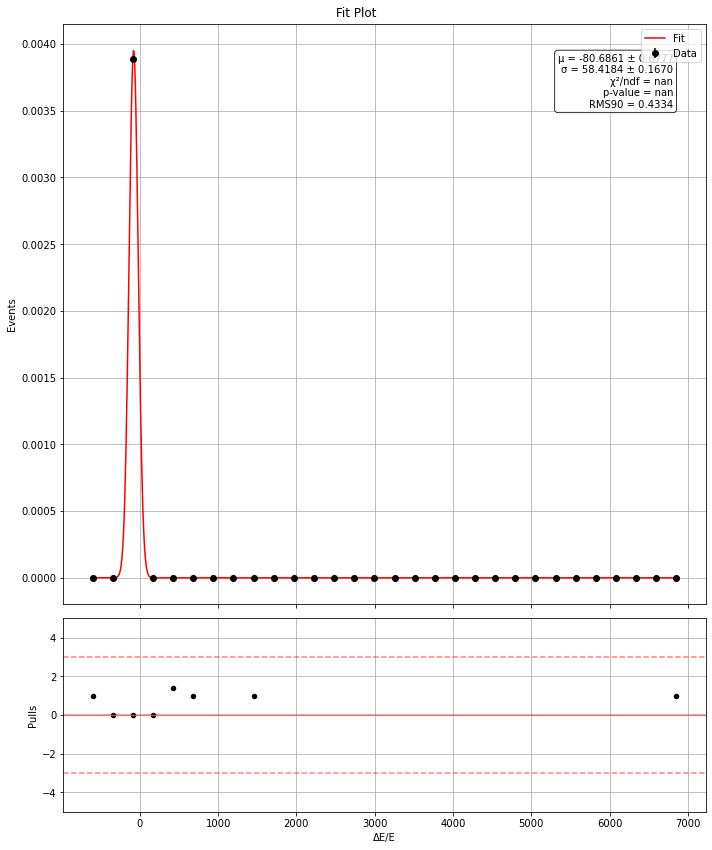

In [99]:
fig = fit_and_plot_scipy(true_values_F, predicted_values_F, title="Fit Plot", bins=30)
plt.show()

In [118]:
def resolution_plot(
    true,
    pred,
    label,
    xlabel=None,
    ax=None,
    color="#8eba42",
    hatch=r"\\\ ",
    fontsize=13,
    plot_range=[-0.5, 0.5],
    bins=100,
):
    """Plot the resolution of a prediction compared to the true value.

    Args:
        true (np.array): True values.
        pred (np.array): Predicted values.
        label (str): Label for the plot.
        color (str): Color for the plot.
        hatch (str): Hatch pattern for the hatched area.
    """

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    # calculate resolution (= relative error) and clipping to plot_range to have overflow bins
    rec_errs = (pred - true) / true
    rec_errs = np.clip(rec_errs, *plot_range)

    # PLOT HISTOGRAM
    values, bin_edges, _ = ax.hist(
        rec_errs,
        bins=bins,
        color=color,
        histtype="step",
        hatch=hatch,
        range=plot_range,
        label=str(label),
        alpha=0.6,
    )

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel("Number of events", fontsize=fontsize)
    ax.legend(loc="center right", fontsize=fontsize)

    return ax

# Resolution Plot: 

Resolution is defined as (pred-true)/true

https://github.com/uzzielperez/gnn_photon_clustering_in_belleII_ecl/blob/main/one_photon_example.ipynb

/tmp/ipykernel_355/1426142530.py:31: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.9.
  values, bin_edges, _ = ax.hist(


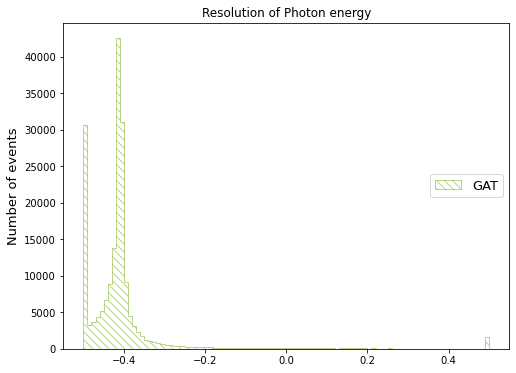

In [120]:
resolution_plot(true_values_F, predicted_values_F, label="GAT")
plt.title("Resolution of Photon energy")
plt.show()

/tmp/ipykernel_355/1426142530.py:31: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.9.
  values, bin_edges, _ = ax.hist(


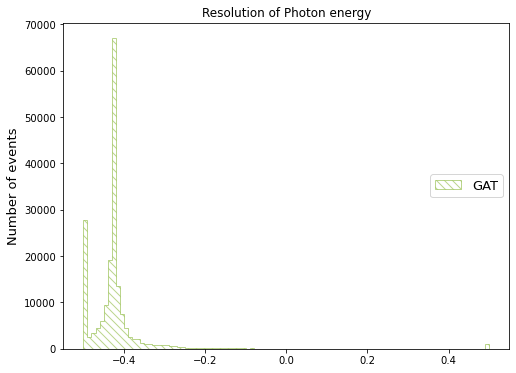

In [121]:
resolution_plot(true_values_B, predicted_values_B, label="GAT")
plt.title("Resolution of Photon energy")
plt.show()